# 👽👾 Sci-fi IRL #2: PrintSF 📚🛸

#### A Predictive Machine Learning Model by Tobias Reaper

#### ---- Datalogue 02-009-02 ----

> XGBClassifier + RandomizedSearchCV

---
---

## Outline

- [Feature Engines](#Feature-Engines)
- [Visualization](#Visualization)
- [Predictive Modeling](#Predictive-Modeling)
  - [Basic Logistic Baseline](#Basic-Logistic-Baseline)
  - [Hyper-parameter Tunes](#Hyper-parameter-Tunes)

---

## TODOjo

#### Model Interpretation

- [x] Permutation Importances (LSDS 232)
- [x] Shap
- [ ] Partial Dependencies
- [ ] Get and interpret confusion matrix (LSDS_224) + precision / recall

---
---

### Imports and Configuration

📥⚙️

In [1]:
# The Utiliteers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extrateers
import seaborn as sns
import janitor
import os

In [2]:
# Plotly imports
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly"  # Set to dark mode

In [3]:
# Jupyter + Plotly imports (if running in Colab or Visual Studio Code, comment out this cell)
import plotly.offline as pyo
pyo.init_notebook_mode()  # Set plotly to notebook mode / work offline

In [4]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [5]:
# Set pandas display options to allow for more columns and rows
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

ML Imports

In [6]:
# ML Infrastructure
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# Extra Crunchy
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import randint, uniform

---

### LowData

In [8]:
# Define path to current session directory - 009
datapath = "/Users/Tobias/workshop/dasci/projects/thepurpledot_dev/stories/sci_fi_irl-02/009-Session/"

# Create path to the books dataset
filename = "must_read_books_009-01.csv"

filepath = os.path.join(datapath, filename)
filepath

'/Users/Tobias/workshop/dasci/projects/thepurpledot_dev/stories/sci_fi_irl-02/009-Session/must_read_books_009-01.csv'

In [9]:
# Load the data
df1 = pd.read_csv(filepath)

In [10]:
print(df1.shape)
df1.head(2)

(18573, 22)


title               author  \
0  The Book of Mormon: Another Testament of Jesus...            Anonymous   
1                                         The Prince  Niccolò Machiavelli   

   num_ratings  num_reviews  avg_rating  num_pages language  fiction  \
0      71355.0       5704.0        4.37      531.0  English        0   
1     229715.0       7261.0        3.81      140.0  English        0   

   short_stories  publish_year  publish_month  publish_day  1_rating_count  \
0              0        2013.0           10.0         22.0          7520.0   
1              0        2003.0            6.0          1.0          5254.0   

   2_rating_count  3_rating_count  4_rating_count  5_rating_count  in_series  \
0          2697.0          2521.0          1963.0         56654.0          0   
1         16827.0         61182.0         80221.0         66231.0          0   

   has_charlist  has_setting  char_x_setting  short_x_series  
0             0            0               0               0  
1             1            0               0               0

---

## Feature Engines

- [x] title begins with "The"
- [x] has subtitle: contains ":"
- [x] title character length
- [x] title word length
- [x] title longest word
- [x] author number of names
- [x] author middle initial
- [x] 1 / 5 star ratio
- [ ] author number of books

In [11]:
# Create new feature that is if the title begins with "The"
df1["the_title"] = df1["title"].str.startswith("The")
df1["the_title"].value_counts()

False    13646
True      4927
Name: the_title, dtype: int64

In [12]:
# New feature - has_subtitle
df1["has_subtitle"] = df1["title"].str.contains(":")
df1["has_subtitle"].value_counts()

False    14871
True      3702
Name: has_subtitle, dtype: int64

In [13]:
# New feature - title character length
df1["title_char_count"] = df1["title"].apply(lambda x: len(x))
df1["title_char_count"].describe()

count    18573.000000
mean        26.762935
std         22.175566
min          1.000000
25%         13.000000
50%         19.000000
75%         32.000000
max        231.000000
Name: title_char_count, dtype: float64

In [14]:
# New feature - title word count
df1["title_word_count"] = df1["title"].apply(lambda x: len(x.split()))
df1["title_word_count"].describe()

count    18573.000000
mean         4.646638
std          3.719907
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         37.000000
Name: title_word_count, dtype: float64

In [15]:
# New feature - title longest word
df1["title_longest_word"] = df1["title"].apply(lambda x: len(max(x.split(), key=len)))
df1["title_longest_word"].describe()

count    18573.000000
mean         7.771658
std          2.415095
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         37.000000
Name: title_longest_word, dtype: float64

In [16]:
# New feature - author number of names
df1["author_name_count"] = df1["author"].apply(lambda x: len(x.split()))
df1["author_name_count"].describe()

count    18573.000000
mean         2.172832
std          0.453123
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: author_name_count, dtype: float64

In [17]:
# Take a look at the long names 
# They aren't really names - they're all saying the author is The Church of Jesus Christ of Latter-Day Saints
print(df1[df1["author_name_count"] > 6].shape)
df1[df1["author_name_count"] > 6].head(1)

(6, 28)


title  \
1045  Book of Mormon, Doctrine and Covenants, Pearl ...   

                                               author  num_ratings  \
1045  The Church of Jesus Christ of Latter-day Saints      25041.0   

      num_reviews  avg_rating  num_pages language  fiction  short_stories  \
1045        731.0        4.35     1310.0  English        0              0   

      publish_year  publish_month  publish_day  1_rating_count  \
1045        1981.0            1.0          1.0          2865.0   

      2_rating_count  3_rating_count  4_rating_count  5_rating_count  \
1045           750.0           909.0           839.0         19678.0   

      in_series  has_charlist  has_setting  char_x_setting  short_x_series  \
1045          0             0            0               0               0   

      the_title  has_subtitle  title_char_count  title_word_count  \
1045      False         False                60                10   

      title_longest_word  author_name_count  
1045                  10                  8

In [18]:
# I'm actually going to filter those out of the dataset
df2 = df1[df1["author_name_count"] < 7]
df2["author_name_count"].describe()

count    18567.000000
mean         2.171002
std          0.441570
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: author_name_count, dtype: float64

In [19]:
# Take a look at the long names now that the outliers are filtered
# All the other ones (6 and lower) look legitimate
print(df2[df2["author_name_count"] > 4].shape)
df2[df2["author_name_count"] > 4].head(1)

(14, 28)


title                      author  num_ratings  num_reviews  \
3832  La vida es sueño  Pedro Calderón de la Barca      13036.0        476.0   

      avg_rating  num_pages language  fiction  short_stories  publish_year  \
3832        3.98      207.0  Spanish        1              0        2001.0   

      publish_month  publish_day  1_rating_count  2_rating_count  \
3832           10.0         22.0           187.0           689.0   

      3_rating_count  4_rating_count  5_rating_count  in_series  has_charlist  \
3832          2942.0          4547.0          4671.0          0             1   

      has_setting  char_x_setting  short_x_series  the_title  has_subtitle  \
3832            1               1               0      False         False   

      title_char_count  title_word_count  title_longest_word  \
3832                16                 4                   5   

      author_name_count  
3832                  5

In [20]:
# New feature - author middle initial
pat = r"\w* (\w. )+ \w*"
df2["author_middle_initial"] = df2["author"].str.contains(pat, regex=True)
df2["author_middle_initial"].value_counts()

/Users/Tobias/.vega/dasci/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



False    18551
True        16
Name: author_middle_initial, dtype: int64

In [21]:
df2[df2["author_middle_initial"] == True].head(1)

title           author  num_ratings  num_reviews  \
60  The Sight of Demons  Darin C.  Brown        558.0         15.0   

    avg_rating  num_pages language  fiction  short_stories  publish_year  \
60        4.51      270.0  English        1              0        2017.0   

    publish_month  publish_day  1_rating_count  2_rating_count  \
60           10.0          6.0             0.0             1.0   

    3_rating_count  4_rating_count  5_rating_count  in_series  has_charlist  \
60            14.0           243.0           300.0          1             0   

    has_setting  char_x_setting  short_x_series  the_title  has_subtitle  \
60            0               0               0       True         False   

    title_char_count  title_word_count  title_longest_word  author_name_count  \
60                19                 4                   6                  3   

    author_middle_initial  
60                   True

In [22]:
# New feature - 1+2 / 4+5 rating ratio
df2["rating_ratio_1_5"] = (df2["1_rating_count"] + df2["2_rating_count"]) / (df2["4_rating_count"] + df2["5_rating_count"])
df2["rating_ratio_1_5"].describe()

count    18484.000000
mean         0.121877
std          0.144848
min          0.000000
25%          0.052019
50%          0.087281
75%          0.147079
max          5.846154
Name: rating_ratio_1_5, dtype: float64

In [ ]:
# New feature - author number of books
df2["num_ratings"].groupby("author").mean()

---

## Models for Posterity

In [24]:
# Replace True / False again after new features
# Simple numerical encoding of Bool
df2 = df2.replace(to_replace={True: 1, False:0})

In [25]:
df2.head(2)

title               author  \
0  The Book of Mormon: Another Testament of Jesus...            Anonymous   
1                                         The Prince  Niccolò Machiavelli   

   num_ratings  num_reviews  avg_rating  num_pages language  fiction  \
0      71355.0       5704.0        4.37      531.0  English        0   
1     229715.0       7261.0        3.81      140.0  English        0   

   short_stories  publish_year  publish_month  publish_day  1_rating_count  \
0              0        2013.0           10.0         22.0          7520.0   
1              0        2003.0            6.0          1.0          5254.0   

   2_rating_count  3_rating_count  4_rating_count  5_rating_count  in_series  \
0          2697.0          2521.0          1963.0         56654.0          0   
1         16827.0         61182.0         80221.0         66231.0          0   

   has_charlist  has_setting  char_x_setting  short_x_series  the_title  \
0             0            0               0               0          1   
1             1            0               0               0          1   

   has_subtitle  title_char_count  title_word_count  title_longest_word  \
0             1                53                 9                   9   
1             0                10                 2                   6   

   author_name_count  author_middle_initial  rating_ratio_1_5  
0                  1                      0          0.174301  
1                  2                      0          0.150773

In [26]:
df2.describe().T

count          mean            std     min  \
num_ratings            18567.0  46971.860721  212431.066563     0.0   
num_reviews            18567.0   2289.956213    7683.005889     0.0   
avg_rating             18567.0      4.029783       0.303243     0.0   
num_pages              17891.0    340.197585     248.919974     0.0   
fiction                18567.0      0.524856       0.499395     0.0   
short_stories          18567.0      0.040879       0.198015     0.0   
publish_year           18283.0   2005.632227      10.708219  1816.0   
publish_month          18283.0      6.689548       3.410713     1.0   
publish_day            18283.0     13.729366      10.042141     1.0   
1_rating_count         18484.0   1049.426423    6485.364634     0.0   
2_rating_count         18484.0   2270.989559   10179.369607     0.0   
3_rating_count         18484.0   8250.647371   32756.342356     0.0   
4_rating_count         18484.0  15484.127570   65584.323195     0.0   
5_rating_count         18484.0  20127.577040  105342.914641     0.0   
in_series              18567.0      0.365433       0.481564     0.0   
has_charlist           18567.0      0.312382       0.463477     0.0   
has_setting            18567.0      0.279151       0.448594     0.0   
char_x_setting         18567.0      0.192761       0.394478     0.0   
short_x_series         18567.0      0.008133       0.089816     0.0   
the_title              18567.0      0.265309       0.441510     0.0   
has_subtitle           18567.0      0.199386       0.399550     0.0   
title_char_count       18567.0     26.758604      22.175949     1.0   
title_word_count       18567.0      4.646039       3.719986     1.0   
title_longest_word     18567.0      7.771153       2.415240     1.0   
author_name_count      18567.0      2.171002       0.441570     1.0   
author_middle_initial  18567.0      0.000862       0.029344     0.0   
rating_ratio_1_5       18484.0      0.121877       0.144848     0.0   

                               25%          50%           75%           max  
num_ratings             387.000000  4138.000000  23119.500000  6.144613e+06  
num_reviews              42.000000   272.000000   1381.500000  1.639810e+05  
avg_rating                3.840000     4.040000      4.220000  5.000000e+00  
num_pages               221.000000   307.000000    402.000000  8.124000e+03  
fiction                   0.000000     1.000000      1.000000  1.000000e+00  
short_stories             0.000000     0.000000      0.000000  1.000000e+00  
publish_year           2001.000000  2008.000000   2013.000000  2.019000e+03  
publish_month             4.000000     7.000000     10.000000  1.200000e+01  
publish_day               3.000000    14.000000     23.000000  3.100000e+01  
1_rating_count            7.000000    70.000000    383.000000  5.096600e+05  
2_rating_count           19.000000   202.000000   1080.000000  4.978850e+05  
3_rating_count           72.000000   829.000000   4467.250000  9.169240e+05  
4_rating_count          132.000000  1444.000000   8050.500000  1.760651e+06  
5_rating_count          145.000000  1480.000000   8701.750000  3.954496e+06  
in_series                 0.000000     0.000000      1.000000  1.000000e+00  
has_charlist              0.000000     0.000000      1.000000  1.000000e+00  
has_setting               0.000000     0.000000      1.000000  1.000000e+00  
char_x_setting            0.000000     0.000000      0.000000  1.000000e+00  
short_x_series            0.000000     0.000000      0.000000  1.000000e+00  
the_title                 0.000000     0.000000      1.000000  1.000000e+00  
has_subtitle              0.000000     0.000000      0.000000  1.000000e+00  
title_char_count         13.000000    19.000000     32.000000  2.310000e+02  
title_word_count          2.000000     3.000000      6.000000  3.700000e+01  
title_longest_word        6.000000     8.000000      9.000000  3.700000e+01  
author_name_count         2.000000     2.000000      2.000000  6.000000e+00  
author_m

In [27]:
df2.shape

(18567, 30)

In [28]:
# Save the current dataframe to file
df2.to_csv("must_read_books_009-02.csv", index=False)

---

## Visualizations

In [29]:
# First, impute the missing number of pages
df2["num_pages"] = df2["num_pages"].fillna(df2["num_pages"].mean())

In [30]:
plt.rcParams['figure.dpi'] = 150

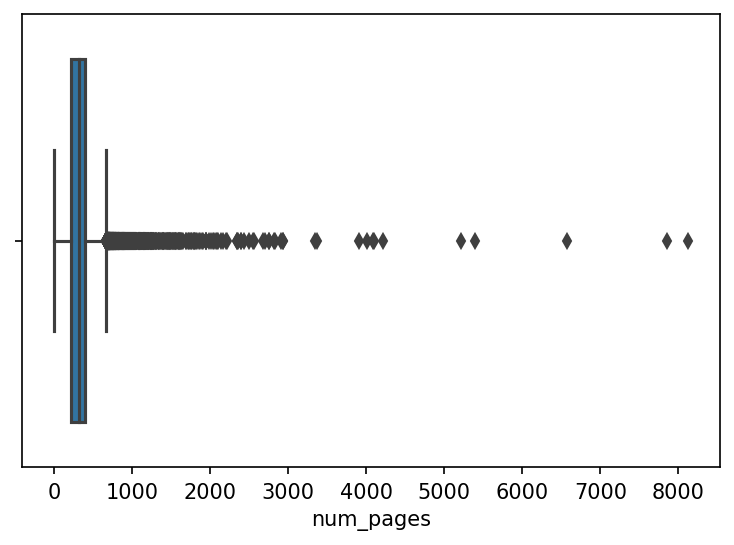

In [32]:
# To find outliers in numerical features, utilize boxplot
sns.boxplot(x=df2["num_pages"]);
# plt.savefig("num_pages_outliers.png", dpi=150)

In [34]:
# See how much removing pages outliers affects dataset
# This could even be one of the sliders on the app
cutoff = 2000
df3 = df2[df2["num_pages"] <= cutoff]
print(f"There are {df2.shape[0] - df3.shape[0]} books above {cutoff} pages long.")
print(f"The resulting dataset has {df3.shape[0]} rows.")

There are 40 books above 2000 pages long.
The resulting dataset has 18527 rows.


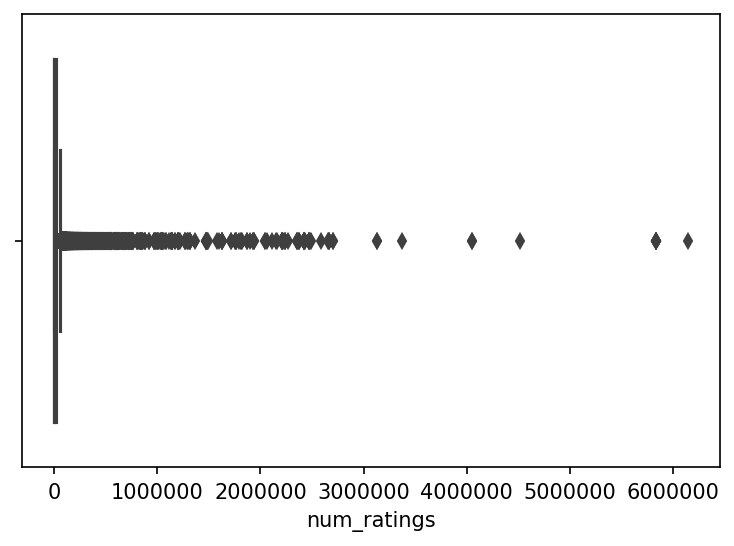

In [35]:
# To find outliers in numerical features, utilize boxplot
sns.boxplot(x=df3["num_ratings"]);
# plt.savefig("num_ratings_outliers.png", dpi=150)

In [36]:
# See how much removing ratings outliers affects dataset
cutoff = 2000000
df4 = df3[df3["num_ratings"] <= cutoff]
print(f"There are {df3.shape[0] - df4.shape[0]} books with above {cutoff} ratings.")
print(f"The resulting dataset has {df4.shape[0]} rows.")

There are 55 books with above 2000000 ratings.
The resulting dataset has 18472 rows.


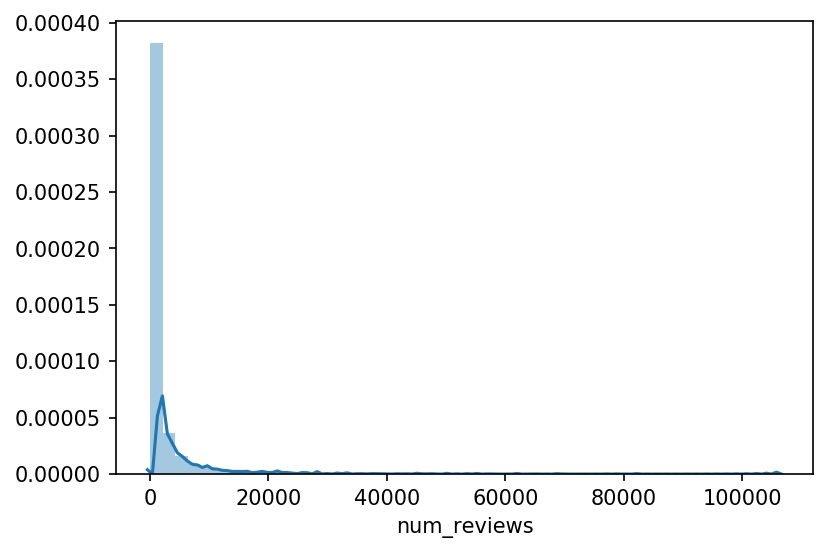

In [37]:
sns.distplot(df4["num_reviews"]);
# plt.savefig("num_reviews_outliers.png", dpi=150)

In [38]:
# See how much removing ratings outliers affects dataset
cutoff = 50000
df5 = df4[df4["num_reviews"] <= cutoff]
print(f"There are {df4.shape[0] - df5.shape[0]} books with above {cutoff} reviews.")
print(f"The resulting dataset has {df5.shape[0]} rows.")

There are 64 books with above 50000 reviews.
The resulting dataset has 18408 rows.


In [39]:
df5["publish_year"].isnull().sum()

283

In [92]:
# See how much removing publish_year outliers affects dataset
cutoff = 1800
df6 = df5[df5["publish_year"] >= cutoff]
print(f"There are {df5.shape[0] - df6.shape[0]} books published before {cutoff}.")
print(f"The resulting dataset has {df6.shape[0]} rows.")

There are 283 books published before 1800.
The resulting dataset has 18125 rows.


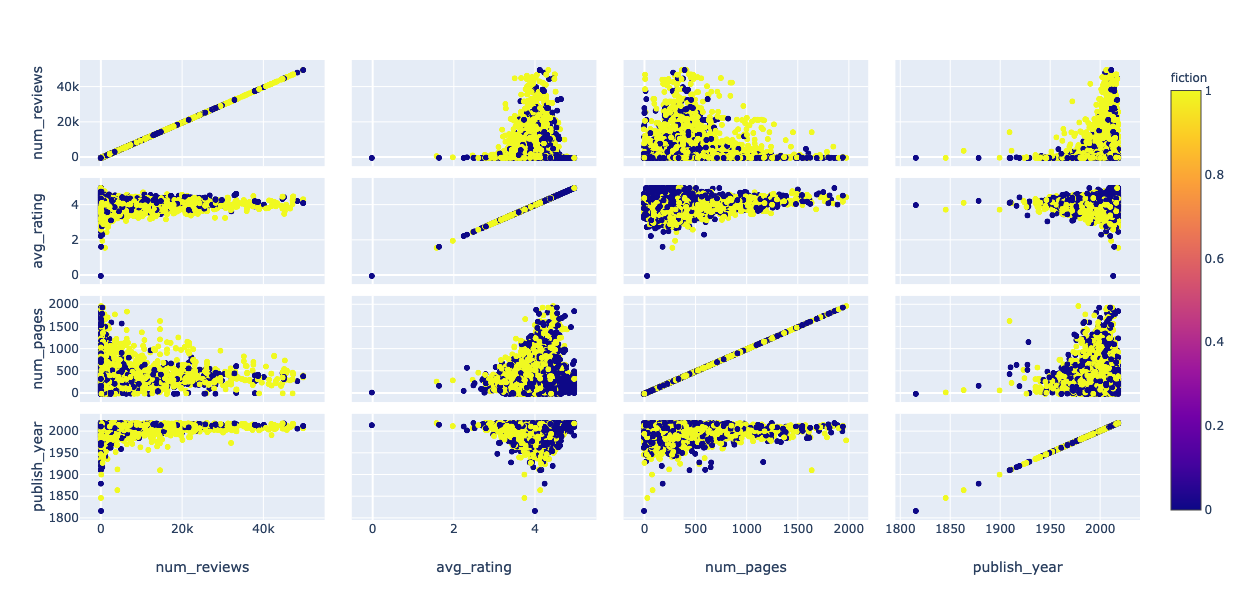

In [110]:
# Scatter Matrix
fig = px.scatter_matrix(df6, dimensions=["num_reviews", "avg_rating", "num_pages", "publish_year"], color="fiction")
fig.show()

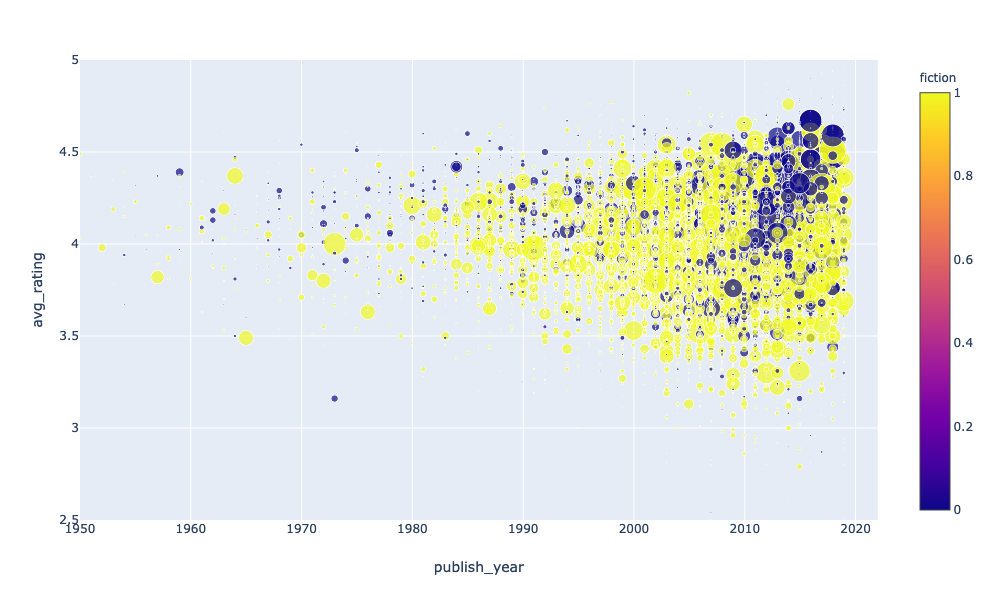

In [113]:
# Higher-dimensional scatter
px.scatter(df6, x="publish_year", y="avg_rating", size="num_reviews", color="fiction", range_y=[2.5, 5], range_x=[1950, 2022])

In [156]:
# Higher-dimensional scatter
# This time on a subset of the data
# df6_f1 = df6[(df6["num_reviews"] >= 500) & (df6["num_reviews"] <= 1000)]
df6_f1 = df6[df6["num_reviews"] >= 500]
df6_f1.shape

(7329, 30)

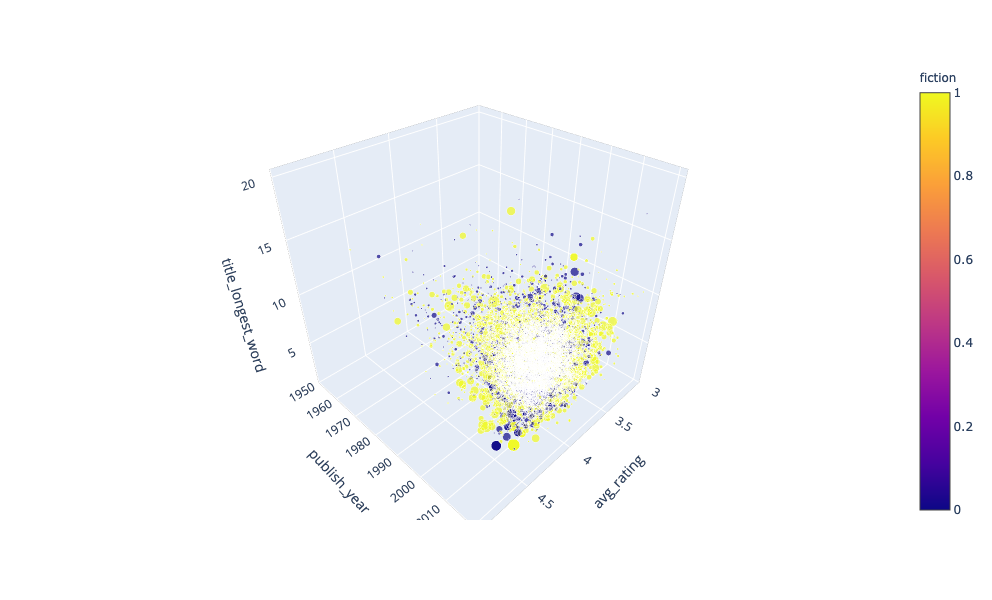

In [158]:
# Plot the subset in 3d space
fig = px.scatter_3d(df6_f1, x="avg_rating", y="publish_year", z="title_longest_word", size="num_reviews", color="fiction", range_x=[3, 5], range_y=[1950, 2022])
fig.show()

In [95]:
# Save the current dataframe to file
df6.to_csv("must_read_books_009-02-no_out.csv", index=False)

---
---

# Predictive Modeling

---

## Target Practice 🎯`fiction`

> Binary Classification

Is it fiction or is in fuction?

In [96]:
# Split up data into train / test
# No validation set because I will be using cross-validation
train, test = train_test_split(df6, test_size=0.2, random_state=92)
train.shape, test.shape

((14500, 30), (3625, 30))

In [97]:
# Define new target "fiction"
target = "fiction"

y_train = train[target]
y_test = test[target]
y_train.shape, y_test.shape

((14500,), (3625,))

In [109]:
# Check target distribution
y_train.value_counts()

1    7561
0    6939
Name: fiction, dtype: int64

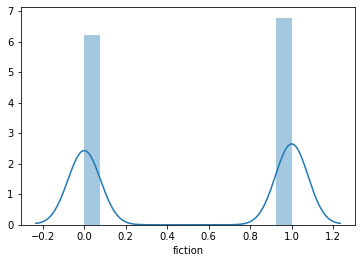

In [108]:
# The target is very evenly distributed
%matplotlib inline
sns.distplot(y_train);

---

#### Majority Baseline

In [99]:
# Get the mode (aka the majoratahhh class)
maj_class = y_train.mode()[0]

# Create predictions of 100% grass-fed respect-mah-majoritaahhh
y_pred_base = [maj_class] * len(y_train)

# See how we did!!
accuracy_score(y_train, y_pred_base)

0.521448275862069

...not too shabby.

Actually...yes it is. Almost as bad as I could get with binary classification.

Just my luck. That's the best I can do.

# 🥺

## $JK!$ I can do better.

> Starting with Logistic Regression

---

## Basic Logistic Baseline

_Unit 2, Sprint 1, Module 4_

> This time, using a couple features and the `fiction` target!

In [100]:
# Arrange X matrices
X1_train = train.drop(columns=[target])
X1_test = test.drop(columns=[target])

X1_train.shape, X1_test.shape

((14500, 29), (3625, 29))

In [101]:
# Create basslinic logistic pipeline
pipe1 = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy="median"),
    LogisticRegressionCV(cv=10, n_jobs=-1, random_state=92),
)

In [102]:
# Fit the pipeline on the training data
pipe1.fit(X1_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['title', 'author', 'language'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'title',
                                          'data_type': dtype('O'),
                                          'mapping': The Adventures of Tom Sawyer        1
The Snow Queen                      2
Cinco horas con Mario               3
Nobody´s Children                   4
Amerika                             5
                                ...  
Warrior's Cross                 14025
لا تقولي إنك خائفة              14026
Summer...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('logisticregressioncv',
            

In [103]:
# Get the baseline cross-validation accuracy scores
scores1 = cross_val_score(pipe1, X1_train, y_train, cv=5)

In [104]:
# Get accuracy scores for the cross-validated logistic model
print("Accuracy score with simple logistic regression using all features: %0.5f (+/- %0.5f)" % (scores1.mean(), scores1.std() * 2))

Accuracy score with simple logistic regression using all features: 0.74241 (+/- 0.02626)


> The new features increased the accuracy of the simple logistic regression model by almost 4%.

---

## Hyper-parameter Tunes

In [105]:
pipe2 = make_pipeline(
    ce.OrdinalEncoder(), 
    IterativeImputer(random_state=92), 
    XGBClassifier(random_state=92),
)

param_distributions = {
    'iterativeimputer__initial_strategy': ["median", "most_frequent"], 
    'iterativeimputer__max_iter': randint(16, 40),
    'iterativeimputer__tol': uniform(0.001, 0.05),
    'iterativeimputer__n_nearest_features': randint(2, 10),
    'iterativeimputer__imputation_order': ["ascending", "roman", "random"],
    'xgbclassifier__n_estimators': randint(100, 300), 
    'xgbclassifier__max_depth': randint(6, 32),
    'xgbclassifier__learning_rate': uniform(0.05, 1), 
}

# Define the search using parameter distros above
search = RandomizedSearchCV(
    pipe2, 
    param_distributions=param_distributions, 
    n_iter=5,
    cv=5, 
    scoring='accuracy',
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1,
    random_state=42,
)

In [106]:
# Fit and search for the best hyperparameters according to above
search.fit(X1_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  1.6min remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('iterativeimputer',
                                              IterativeImputer(add_indicator=False,
                                                               estimator=None,
                                               

In [107]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best hyperparameters {'iterativeimputer__imputation_order': 'roman', 'iterativeimputer__initial_strategy': 'most_frequent', 'iterativeimputer__max_iter': 30, 'iterativeimputer__n_nearest_features': 7, 'iterativeimputer__tol': 0.010983689107917988, 'xgbclassifier__learning_rate': 0.5642344384136116, 'xgbclassifier__max_depth': 30, 'xgbclassifier__n_estimators': 230}
Accuracy 0.7870344827586206


> Feature Engineering increased the accuracy of the XGB classification model by over 6%.

> ~0.7149 -> 0.7870

---
---

## Next Up: Process and Interpretation 🤔

---
---